<a href="https://colab.research.google.com/github/ShedovaNastya/Face-Recognition-Project/blob/main/TripletLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Triplet Loss — это один из лоссов для contrastive learning. Чтобы учить модель с помощью этого лосса, модели не нужен последний классификационный слой. Этот лосс работает прямо с эмбеддингами $x_i$ элементов, которые выдает модель.

Снова скажем, что идея лосса — заставить эмбеддинги лиц одного человека быть более близкими по некоторому расстоянию, а эмбеддинги лиц разных людей — далекими друг от друга. Общая формула лосса выглядит так:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

здесь
- $e$ — эмбеддинг входного лица (output модели)
- $p$ — "positive" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были близки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото одного и того же человека).
- $n$ — "negative" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были далеки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото разных людей).
- $d(x, y)$ — метрика расстояния между эмбеддингами, по которой мы их сравниваем.
- margin — гиперпараметр, который заставляет $d(a, p)$ и $d(a, n)$ быть еще дальше друг от друга.

**Эмбеддинги $e$, $p$ и $n$ нужно нормализовать, прежде чем подавать в лосс-функцию**.

У TripletLoss есть куча разных вариаций. В некоторых из них больше гиперпараметров, в других предлагают использовать больше одного позитивного и негативного эмбеддинга за раз. Где-то предлагается умный способ выбора negative эмбеддинга (например, выбирается такой, на котором нейросеть пока плохо работает, т.е. считает $e$ и $n$ близкими).

Пример реализации TripletLoss можно найти [здесь](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss).

Будьте готовы, что TripletLoss придется настраивать, чтобы добиться хорошего результата при обучении сети.


**Что нужно учесть при реализации Triplet Loss**:
- при обучении мы обычно хотим следить за ходом обучения модели, считая какую-то метрику качества. Тут у нас больше нет классификационного слоя, так что accuracy мы считать не можем. Нужно придумать, как в случае Triplet Loss считать метрику качества на вализации в течение обучения. Подумайте, как можно это сделать?
- скорее всего, чтобы обучить сеть на Triplet Loss, придется написать кастомный Dalaset/Dataloader, который будет возвращать тройки элементов (anchor, positive, negative).
- не забудьте нормализовать эмбеддинги перед подсчетом лосса! Это можно сделать руками, а можно, например, добавить в конец сети batchnorm без обучаемых параметров.

**Доплитература по Triplet Loss**:

- Идея TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss
- Хорошая статья про batch mining techniques для выбора positive и negative элементов: https://omoindrot.github.io/triplet-loss#triplet-mining
- Реализация TripletLoss в PyTorch : https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss
- Еще одна реализация TripletLoss: https://github.com/alfonmedela/triplet-loss-pytorch/blob/master/loss_functions/triplet_loss.py

In [85]:
!pip install torchmetrics

import torch
from torch.utils.tensorboard import SummaryWriter
import os
from IPython.display import clear_output
import numpy as np
from PIL import Image
import torchvision.transforms as T
import torchvision.utils
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.models import list_models, get_model
from tqdm.notebook import tqdm as bar
from copy import deepcopy
from torchmetrics.functional import pairwise_cosine_similarity
from collections import defaultdict

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/celebA_train_500.zip
clear_output()

#DATASET

In [ ]:
class FaceDataset(torch.utils.data.Dataset):

    def __init__(self, images_folder, label_folder, sample_folder, type_dataset, transform):
      """
      image_folder: путь до папки с изображениями
      label_folder: путь до файла, где какой человек находится
      sample_folder: путь до файла к какому датасету относится конкретное изображение
      type_dataset: датасет, который нас сейчас интересует
      transform: преобразование изображения
      """
      self.images_folder = images_folder
      self.label_folder = label_folder
      self.sample_folder = sample_folder
      self.type_dataset = type_dataset
      self.transform = transform


      with open(self.label_folder, 'r') as file: #человек
        self.labels = {}
        for i in file.readlines():
          key, value = i.split()
          self.labels[key] = int(value)

      with open(self.sample_folder, 'r') as file: #классификация датасетов
        self.samples = {}
        for i in file.readlines():
          key, value = i.split()
          self.samples[key] = int(value)

      self.files = [i for i in os.listdir(self.images_folder) if self.samples.get(i, 5) == self.type_dataset]

    def __len__(self):
      return len(self.files)

    def __getitem__(self, idx):
      image_name = self.images_folder + self.files[idx]
      image = np.array(Image.open(image_name))
      image = Image.fromarray(image[77:-41,45:-50])
      label = int(self.labels[self.files[idx]])
      image = self.transform(image)
      return image, label




In [ ]:
train_dataset = FaceDataset('/content/celebA_train_500/celebA_imgs/',
                            '/content/celebA_train_500/celebA_anno.txt',
                            '/content/celebA_train_500/celebA_train_split.txt',
                            0,
                            T.Compose([
                                T.Resize((224, 224)), T.ToTensor()
                            ]))
val_dataset = FaceDataset('/content/celebA_train_500/celebA_imgs/',
                            '/content/celebA_train_500/celebA_anno.txt',
                            '/content/celebA_train_500/celebA_train_split.txt',
                            1,
                            T.Compose([
                                T.Resize((224, 224)), T.ToTensor()
                            ]))
test_dataset = FaceDataset('/content/celebA_train_500/celebA_imgs/',
                            '/content/celebA_train_500/celebA_anno.txt',
                            '/content/celebA_train_500/celebA_train_split.txt',
                            2,
                            T.Compose([
                                T.Resize((224, 224)), T.ToTensor()
                            ]))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 30, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 30, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 30, shuffle = False)

#ID RATE

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip /content/drive/MyDrive/celebA_train_500.zip
!unzip /content/drive/MyDrive/celebA_ir.zip
clear_output()

Identificaton rate metric


In [92]:
f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = ['./celebA_ir/celebA_query/' + x[0] for x in query_lines]

query_dict = defaultdict(list)
for img_name, img_class in query_lines:# словарь ключ- id, значения- изображения, принадлежащие id
  query_dict[img_class].append('./celebA_ir/celebA_query/' + img_name)

distractors_img_names =['./celebA_ir/celebA_distractors/' + i for i in os.listdir('./celebA_ir/celebA_distractors')]#хранятся названия изображений из distractors



In [ ]:
query_dict

defaultdict(list,
            {'35': ['./celebA_ir/celebA_query/001265.jpg',
              './celebA_ir/celebA_query/001430.jpg',
              './celebA_ir/celebA_query/012834.jpg',
              './celebA_ir/celebA_query/041171.jpg',
              './celebA_ir/celebA_query/041823.jpg',
              './celebA_ir/celebA_query/052547.jpg',
              './celebA_ir/celebA_query/071369.jpg',
              './celebA_ir/celebA_query/087722.jpg',
              './celebA_ir/celebA_query/101493.jpg',
              './celebA_ir/celebA_query/113930.jpg',
              './celebA_ir/celebA_query/133927.jpg',
              './celebA_ir/celebA_query/136309.jpg',
              './celebA_ir/celebA_query/140075.jpg',
              './celebA_ir/celebA_query/153974.jpg',
              './celebA_ir/celebA_query/154402.jpg',
              './celebA_ir/celebA_query/161094.jpg'],
             '53': ['./celebA_ir/celebA_query/001171.jpg',
              './celebA_ir/celebA_query/009811.jpg',
              '

In [93]:
class id_rate_dataset(torch.utils.data.Dataset):
  def __init__(self, images_list, transform):
    self.images_list = images_list
    self.transform = transform
  def __len__(self):
    return len(self.images_list)

  def __getitem__(self, idx):
    image_name = self.images_list[idx]
    image = Image.open(image_name)
    image = self.transform(image)
    return image




In [ ]:
# Модель для оценки
#m1 = get_model("efficientnet_b0", weights="IMAGENET1K_V1")

'''m8 = get_model("efficientnet_b3", weights="IMAGENET1K_V1")
m8.classifier[1] = torch.nn.Linear(in_features=1536, out_features=500, bias=True)
device = 'cpu'
m8 = m8.to(device)


filename = '/content/drive/MyDrive/tripletloss_efficientnet_b3_param_m8.pth'
m8.load_state_dict(torch.load(filename, map_location=device))

m8.classifier = m8.classifier[:1]'''


'm8 = get_model("efficientnet_b3", weights="IMAGENET1K_V1")\nm8.classifier[1] = torch.nn.Linear(in_features=1536, out_features=500, bias=True)\ndevice = \'cpu\'\nm8 = m8.to(device)\n\n\nfilename = \'/content/drive/MyDrive/tripletloss_efficientnet_b3_param_m8.pth\'\nm8.load_state_dict(torch.load(filename, map_location=device))\n\nm8.classifier = m8.classifier[:1]'

In [94]:
!du -h celebA_ir/celebA_query/

4.9M	celebA_ir/celebA_query/


In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = torch.tensor([
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
])

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = torch.tensor([
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
])


In [116]:
def compute_embeddings(model, images_list):#функция считает выход ембеддингового слоя
  '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images
          names from images_list
  '''
  out_data = []
  dataset = id_rate_dataset(images_list,  T.Compose([T.Resize((224, 224)), T.ToTensor()]))
  loader = DataLoader(dataset, batch_size = 30, shuffle = False)

  model.to(device)
  model.eval()
  correct = 0
  with torch.no_grad():
    for data in loader:
      data = data.to(device)

      out_data.append(model(data))
  return torch.cat(out_data)


#query_embeddings = compute_embeddings(m8, query_img_names)

In [96]:
def cosine_similarity(list_em, list_em2):
  em1 = torch.Tensor(list_em)
  em1 = em1.to(device)
  em2 = torch.Tensor(list_em2)
  em2 = em2.to(device)
  similarity= pairwise_cosine_similarity(em1,em2)
  similarity = similarity.to(device)
  return similarity

In [97]:
a = torch.randn(size=(3,3))
a = a.to(device)
cosine_similarity(a,a)

tensor([[ 1.0000, -0.7822,  0.3859],
        [-0.7822,  1.0000, -0.7388],
        [ 0.3859, -0.7388,  1.0000]])

In [110]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings czorresponding
                    to the same people from query list

    '''
  similarity = []
  images = {name:idx for idx, name in enumerate(query_img_names)}#словарь ключ - имя изображения, значение - индекс в query_img_names
  for id in query_dict.keys():#идем по каждому лицу
    emb = []
    img_id = query_dict[id]#получаю список изображений, принадлежащих одному лицу
    for img in img_id:# иду по кааждому изображению
      emb.append(query_embeddings[images[img]].unsqueeze(0))#добавляю в список ембеддинг каждой фотки, unsqeeze - добавляет размерность фиктивную [[...]] [[...]]
    emb = torch.cat(emb)#[[...],[...]]
    emb = emb.to(device)
    matrix = cosine_similarity(emb, emb)
    matrix = matrix.to(device)
    mask = torch.triu(torch.ones_like(matrix), diagonal=1)# triu- верх.треугольник, ones_like - все единицы, diagonal=1 - по нулям
    mask = mask.to(device)
    matrix = matrix[mask == 1]
    if len(matrix) > 0:# обрабатываем случай когда у одного лица лолько одно изображение,добавлять тогда не будем
      similarity.append(matrix)
  return torch.cat(similarity)


'''cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, query_embeddings)
test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
true_cosine_query_pos = torch.Tensor([0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561])
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"
print(test_cosine_query_pos)'''

'cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, query_embeddings)\ntest_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,\n                                            test_query_embeddings)\ntrue_cosine_query_pos = torch.Tensor([0.8678237233650096, 0.21226104378511604,\n                         -0.18355866977496182, 0.9787437979250561])\nassert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)),       "A mistake in compute_cosine_query_pos function"\nprint(test_cosine_query_pos)'

In [111]:
def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to different people from query list
  '''
  similarity = []
  keys_id = list(query_dict.keys())

  images = {name:idx for idx, name in enumerate(query_img_names)}#словарь ключ - имя изображения, значение - индекс в query_img_names

  for id1 in range(len(keys_id)):
    emb1 = []
    images1 = query_dict[keys_id[id1]]
    for img in images1:
      emb1.append(query_embeddings[images[img]].unsqueeze(0))
    emb1 = torch.cat(emb1)
    emb1 = emb1.to(device)
    for id2 in range(id1+1,len(keys_id)):
      images2 = query_dict[keys_id[id2]]
      emb2 = []
      for img in images2:
        emb2.append(query_embeddings[images[img]].unsqueeze(0))
      emb2 = torch.cat(emb2)
      emb2 = emb2.to(device)
      # print(cosine_similarity(emb1, emb2))
      similarity.append(cosine_similarity(emb1, emb2).view(-1))#здесь разворачиваем двумерный тензор в массивчик тензоров через view
      similarity = similarity.to(device)
      # break
    # break

  return torch.cat(similarity)



'''test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)



true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
print(test_cosine_query_neg)
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"'''


'test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,\n                                            test_query_embeddings)\n\n\n\ntrue_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,\n                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,\n                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,\n                         -0.011982733001947084, -0.0466679194884999]\nprint(test_cosine_query_neg)\nassert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)),       "A mistake in compute_cosine_query_neg function"'

In [112]:
def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
  '''
  compute cosine similarities between negative pairs from query and distractors
  (stage 3)
  params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
  output:
    list of floats: similarities between pairs of people (q, d), where q is
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
  '''
  similarity = []
  batch_size = 50
  for q in range(0, len(query_embeddings), batch_size):
    emb1 = query_embeddings[q: q + batch_size]
    emb1 = emb1.to(device)
    for d in range(0,len(distractors_embeddings), batch_size):
      emb2 = distractors_embeddings[d:d+batch_size]
      emb2 = emb2.to(device)
      similarity.append(cosine_similarity(emb1, emb2).view(-1))
      similarity = similarity.to(device)
  return torch.cat(similarity)



  raise NotImplementedError


'''test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)


true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"'''

'test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,\n                                                            test_distractors_embeddings)\n\n\ntrue_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,\n                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,\n                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,\n                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,\n                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,\n                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,\n                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,\n                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,\n                                 -0.40749654

In [ ]:
test_cosine_query_pos

tensor([ 0.8678,  0.2123, -0.1836,  0.9787])

In [113]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
  '''
  compute identification rate using precomputer cosine similarities between pairs
  at given fpr
  params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs
                              from query and distractors
    fpr: false positive rate at which to compute TPR
  output:
    float: threshold for given fpr
    float: TPR at given FPR
  '''
  cnt_false = len(cosine_query_neg) + len(cosine_query_distractors)
  n = int(cnt_false * fpr)
  false_pars = np.concatenate([cosine_query_neg.cpu().numpy(), cosine_query_distractors.cpu().numpy()])
  false_pars = np.sort(false_pars)[::-1]
  false_pars = false_pars.to(device)
  threshold = false_pars[n]
  threshold = threshold.to(device)
  # print(n)
  # print(false_pars)
  cosine_query_pos = cosine_query_pos.cpu().numpy()
  cosine_query_pos = cosine_query_pos.to(device)
  num_true_positive = np.sum(cosine_query_pos >= threshold)
  num_true_positive = num_true_positive.to(device)
  return threshold, num_true_positive/ len(cosine_query_pos)

In [ ]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [ ]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

NameError: name 'test_thr' is not defined

In [ ]:
test_thr

[-0.011982724, 0.33714268, 0.70130706]

#Triplet Loss


In [ ]:
def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.

    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    embeddings = embeddings.float()
    dot_product = torch.matmul(embeddings, torch.transpose(embeddings, 0, 1))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = torch.diagonal(dot_product, 0)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = torch.unsqueeze(square_norm, 0) - 2.0 * dot_product + torch.unsqueeze(square_norm, 1)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = torch.maximum(distances, torch.tensor(0.0, requires_grad=True))

    return distances

In [ ]:
def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.

    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]

    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = torch.eye(labels.size(0)).bool()
    indices_not_equal = ~indices_equal.to('cuda')

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1)).to('cuda')

    # Combine the two masks
    mask = torch.logical_and(indices_not_equal, labels_equal)

    return mask

In [ ]:
def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.

    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]

    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1))

    mask = ~labels_equal

    return mask

In [ ]:
def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.

    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]

    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = torch.eye(labels.size(0)).bool()
    indices_not_equal = ~indices_equal
    i_not_equal_j = indices_not_equal.unsqueeze(2)
    i_not_equal_k = indices_not_equal.unsqueeze(1)
    j_not_equal_k = indices_not_equal.unsqueeze(0)

    distinct_indices = torch.logical_and(torch.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k).to('cuda')


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1))
    i_equal_j = label_equal.unsqueeze(2)
    i_equal_k = label_equal.unsqueeze(1)

    valid_labels = torch.logical_and(i_equal_j, ~(i_equal_k)).to('cuda')

    # Combine the two masks
    mask = torch.logical_and(distinct_indices, valid_labels)

    return mask

In [ ]:
def batch_all_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.

    We generate all the valid triplets and average the loss over the positive ones.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    anchor_positive_dist = torch.unsqueeze(pairwise_dist, 2)
    anchor_negative_dist = torch.unsqueeze(pairwise_dist, 1)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = mask.float()
    triplet_loss = torch.mul(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = torch.maximum(triplet_loss, torch.tensor(0.0, requires_grad=True))

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = (triplet_loss > 1e-16).float()
    num_positive_triplets = torch.sum(valid_triplets)
    num_valid_triplets = torch.sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = torch.sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets

In [ ]:
def batch_hard_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.

    For each anchor, we get the hardest positive and hardest negative to form a triplet.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = mask_anchor_positive.float()

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = torch.mul(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist, _ = torch.max(anchor_positive_dist, dim=1, keepdim=True)

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = mask_anchor_negative.float()

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist, _ = torch.max(pairwise_dist, dim=1, keepdim=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist, _ = torch.min(anchor_negative_dist, dim=1, keepdim=True)

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = torch.max(hardest_positive_dist - hardest_negative_dist + margin, torch.tensor(0.0, requires_grad=True))

    # Get final mean triplet loss
    triplet_loss = torch.mean(triplet_loss)

    return triplet_loss

#MODEL EfficientNet_B3_Weights.IMAGENET1K_V1 + Triplet Loss



In [128]:
def model_tripletloss(triplet_strategy):
  epoches = 5
  batch_size = 2640

  #device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  m8 = get_model("efficientnet_b3", weights="IMAGENET1K_V1")
  #m8.classifier[1] = torch.nn.Linear(in_features=1536, out_features=500, bias=True)
  m8 = m8.to(device)
  optimizer = torch.optim.Adam(m8.parameters())


  train_loss_history = []
  val_loss_history = []

  best_state = None # веса
  best_tpr = 0


  for epoch in bar(range(epoches), desc='learning'):
    m8.train()
    loss_epoch= 0
    correct = 0
    for data, label in bar(train_loader, desc = 'epoch'):
      data = data.to(device)#30 картинок
      label = label.to(device)#30 людей

      optimizer.zero_grad()
      outputs = m8(data) #.int()

      if triplet_strategy == 'batch_all':
        loss_fn, fraction = batch_all_triplet_loss(label, outputs, margin=1, squared=True)
      elif triplet_strategy == 'batch_hard':
        loss_fn = batch_hard_triplet_loss(label, outputs, margin=1, squared=True)

      loss = torch.mean(loss_fn)
      loss.backward()
      loss = loss.to(device)

      optimizer.step()
      loss_epoch += loss.item()#скалярное значение loss




    train_loss_history.append(loss_epoch / len(train_loader))#для одного лоадера


    m8.eval()
    loss_epoch= 0
    correct = 0
    with torch.no_grad():
      for data, label in bar(val_loader, desc = 'epoch'):
        data = data.to(device)#30 картинок
        label = label.to(device)#30 людей

        outputs = m8(data)

        if triplet_strategy == 'batch_all':
          loss_fn, fraction = batch_all_triplet_loss(label, outputs, margin=1, squared=True)
        elif triplet_strategy == 'batch_hard':
          loss_fn = batch_hard_triplet_loss(label, outputs, margin=1, squared=True)

        loss = torch.mean(loss_fn)

        loss_epoch += loss.item()#скалярное значение loss

    val_loss_history.append(loss_epoch / len(val_loader))#для одного лоадера

    '''query_embeddings = compute_embeddings(m8, query_img_names)
    query_embeddings = query_embeddings.to(device)

    distractors_embeddings = compute_embeddings(m8, distractors_img_names)
    distractors_embeddings = distractors_embeddings.to(device)

    cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, query_embeddings)
    cosine_query_pos = cosine_query_pos.to(device)

    cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, query_embeddings)
    cosine_query_neg = cosine_query_neg.to(device)

    cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distractors_embeddings)
    cosine_query_distractors = cosine_query_distractors.to(device)

    thr = []
    tpr = []

    for fpr in [0.5, 0.1, 0.05, 0.01]:#0.01 при 1% когда он допускает разных людей одинаковыми, то при 0,44 верно предсказывает на изображении одного и того же человека
      x, y = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr)
      x = x.to(device)
      y = y.to(device)
      thr.append(x)
      tpr.append(y)
      thr = thr.to(device)
      tpr = tpr.to(device)



    if best_tpr >= tpr[-1]:
      best_tpr = tpr[-1]
      best_state = deepcopy(m8.state_dict())'''


    '''clear_output()
    plt.figure(figsize=(16,10))
    plt.suptitle(f'epoch {epoch+1}/ {epoches} best accuracy {best_acc}')
    plt.title('efficientnet_b3 accuracy')
    plt.plot(train_accuracy_history, label='train accuracy', color = 'purple')
    plt.plot(val_accuracy_history, label='val accuracy', color = 'green')
    plt.legend(loc='best')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()'''

    plt.figure(figsize=(16,10))
    # plt.suptitle(f'epoch {epoch+1}/ {epoches}  loss {loss_epoch}')
    plt.title('efficientnet_b3 loss')
    plt.plot(train_loss_history, label='train loss', color = 'purple')
    #plt.plot(val_loss_history, label='val loss', color = 'green')
    plt.legend(loc='best')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    '''plt.figure(figsize=(16,10))
    plt.title('id rate')
    plt.plot(thr, label='thr', color = 'purple')
    plt.plot(tpr, label='tpr', color = 'green')
    plt.legend(loc='best')
    plt.xlabel('epoch')
    plt.ylabel('rate')
    plt.show()'''

    '''# Metrics for evaluation
    eval_metric_ops = {}
    embedding_mean_norm = torch.mean(outputs)
    eval_metric_ops['embedding_mean_norm'] = embedding_mean_norm.item()

    if triplet_strategy == "batch_all":
        fraction_positive_triplets = torch.mean(fraction)
        eval_metric_ops['fraction_positive_triplets'] = fraction_positive_triplets.item()

    # Summaries for training
    writer = SummaryWriter()

    writer.add_scalar('loss', loss.item())
    if triplet_strategy == "batch_all":
        writer.add_scalar('fraction_positive_triplets', fraction.item())

    # Assuming images is a tensor of images
    img_grid = torchvision.utils.make_grid(data, nrow=1)
    writer.add_image('train_image', img_grid)

    # Close the writer when done
    writer.close()'''

    '''filename = '/content/drive/MyDrive/tripletloss_efficientnet_b3_param_m8.pth'
    torch.save(best_state, filename)
    m8.load_state_dict(torch.load(filename))
    m8.eval()
    loss_epoch = 0
    correct = 0
    with torch.no_grad():
      for data, label in test_loader:
        data = data.to(device)#30 картинок
        label = label.to(device)#30 людей

        outputs = m8(data).to(device)'''


learning:   0%|          | 0/5 [00:00<?, ?it/s]

epoch:   0%|          | 0/285 [00:00<?, ?it/s]

epoch:   0%|          | 0/63 [00:00<?, ?it/s]

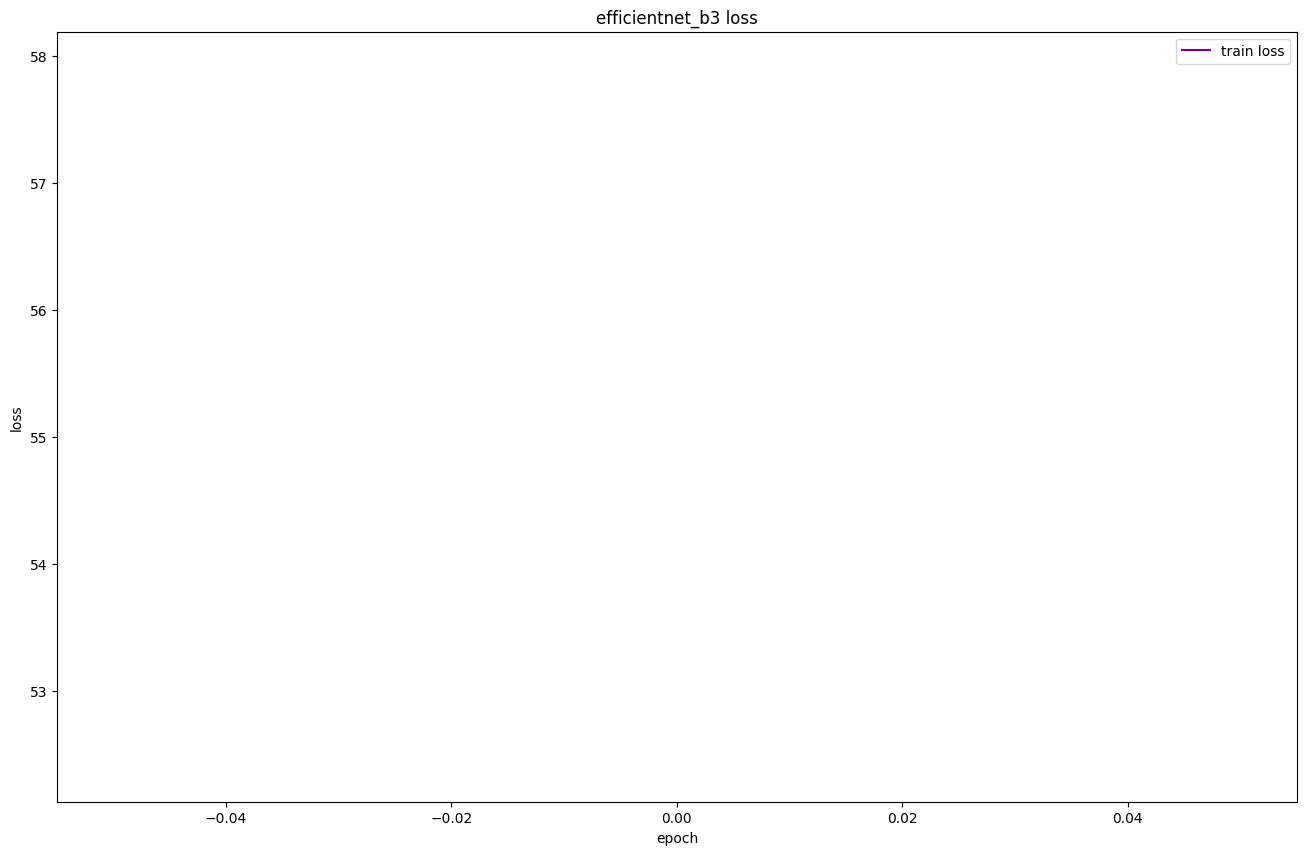

epoch:   0%|          | 0/285 [00:00<?, ?it/s]

epoch:   0%|          | 0/63 [00:00<?, ?it/s]

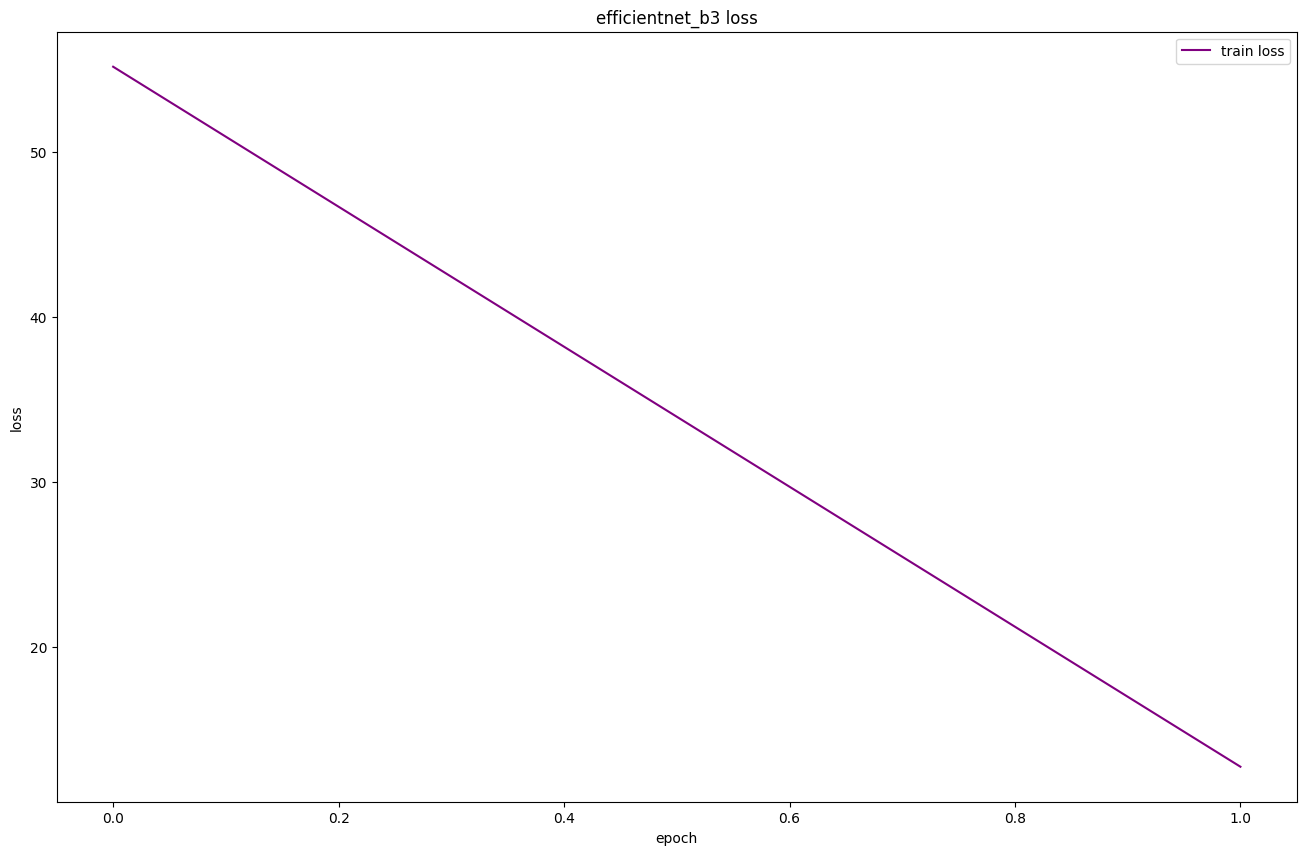

epoch:   0%|          | 0/285 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [129]:
model_tripletloss('batch_all')

In [ ]:
model_tripletloss('batch_hard')

learning:   0%|          | 0/5 [00:00<?, ?it/s]

epoch:   0%|          | 0/285 [00:00<?, ?it/s]